This notebook will be used to write code and investigate the accuracy of rank 1 tensor approximations using HOSVD?

In [28]:
using Plots
using Makie
using GraphMakie.NetworkLayout
using CairoMakie
using Tenet
using TensorOperations
using LinearAlgebra
using EinExprs
using Combinatorics
using LaTeXStrings
Makie.inline!(true)
include("julia_functions.jl")

generate_combinations (generic function with 1 method)

This function takes in a Tenet.Tensor and computes the best rank-one-approximation for this specific tensor.
The best rank-one-approximation is defined is $T_{ijkl} = \Omega U^i \otimes U^j \otimes U^k \otimes U^l$. The functions return all the vectors $U^{index}$ and the constant $\Omega$.

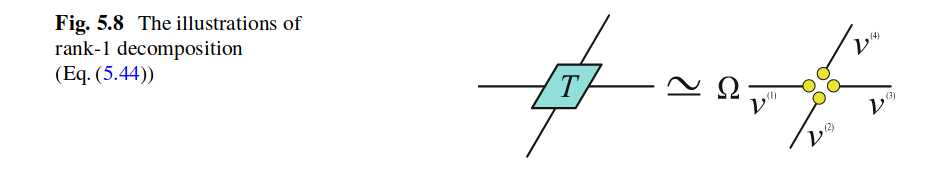

In [29]:
test = Tenet.Tensor(rand(3,3,3,3,3), (Symbol("i"), Symbol("j"), Symbol("k"), Symbol("l"), Symbol("m")))
println(size(test))

function matricisation_fold(Tensor, index)

    """
    Function takes in a Tenet.Tensor and computes its folded version.
    i.e. A Matricization such that the Tensor is restructured as A{index}{prod all indices} with a new symbol as the concatenated string of all indices
    """ 

    # Compute the dimension of the new bond -> this new bond has the size of the product of the grouped dimensions

    indices = inds(Tensor) # all indices of the Tensor
    ix = findfirst(x -> x == index, indices) # the integer index of the symbol index
    
    
    # Create two groups based on the selected index
    group1 = index
    group2 = vcat(indices[(ix+1):end], indices[1:ix-1]) # employed the correct unfolding definition as in the paper.

    dim_new = prod(size(Tensor, index) for index in group2) # compute the dimension of the new grouped bond
    
    # generate a permutation order of indices which puts the to group indices in the end
    # by reshaping the underlying data array -> (dim(complementind_T1)..., dim_new) the correct parts of the data array are grouped

    new_order = [[index]..., group2...] # indices to keep at front

    # Permute the dimensions based on the new order
    permuted_tensor = permutedims(Tensor, new_order)

    # extract the permuted tensor data to be reshaped
    new_tensor_data_array = permuted_tensor.data

    # perform the reshaping and create new tensors with grouped index
    new_index = join([string(ix) for ix in group2], "")

    # create reshape lists -> casted to tuple for the reshape function
    # reshape lists are based on sizes of the underlying data arrays
    # vcat vertically concatenates two arrays

    tensor_reshape_list = vcat([size(Tensor, index)], dim_new)

    # Create the new tensors based on the the reshaped data array and on a tuple containing the untouched indices and the newly grouped index

    tensor_new = Tenet.Tensor(reshape(new_tensor_data_array, tensor_reshape_list...), ([index]..., Symbol(new_index)))

    return tensor_new

end

function extract_dominant_left_singular_vector(M)

    """
    Input is a matrix M and output is the dominant left singular vector. This is the vector corresponding to biggest singular value.
    """

    U, s, Vt = LinearAlgebra.svd(M)
    return U[:, 1]

end

function extract_initial_vectors(Tensor)

    """
    Helper function to extract an initial list of vetors U^i
    """

    initial_vectors = []
    indices = inds(Tensor)
    for index in indices[2:end]
        folded = matricisation_fold(Tensor, index)
        push!(initial_vectors, extract_dominant_left_singular_vector((folded).data))
    end
    return initial_vectors 
end

function compute_outer_product(vectors)

    """
    Helper function to compute the outer product for an array of vectors
    """

    result = reshape(kron(reverse(vectors)...), (length.(vectors))...)


end

function compute_kronecker_product(vectors)

    """
    Helper function to compute the outer product for an array of vectors
    """

    num_vectors = length(vectors)
    # Check if there are at least two vectors for the tensor product
    @assert num_vectors >= 2
    # Initialize the result with the tensor product of the first two vectors
    result = kron(vectors[1], vectors[2])
    # Compute the tensor product with the remaining vectors
    for i in 3:num_vectors
        result = kron(result, vectors[i])
    end

    return result
end




function compute_rank_one_approximation(Tensor, eps, max_iter)

    #TODO: The error condition somehow doesn't work according to plan

    """
    Main algorithmic implementation of the computation of rank one approximations for a Tensor
    """

    indices = inds(Tensor) #length of this is the amount of vectors that we need to compute
    start_vectors = extract_initial_vectors(Tensor)
    U1_ = matricisation_fold(Tensor, inds(Tensor)[1]).data * (compute_kronecker_product(start_vectors))
    lambda = LinearAlgebra.norm(U1_)
    U1 = U1_/lambda

    # creation of initial array of {U_1, U_2, ..., U_N}
    optimized_output_vectors_old = [U1, start_vectors...]
   
    #optimization loop for all vectors till we reach convergence or reach the max_iter specifications
    optimized_output_vectors_new = nothing




    for step in 1:max_iter
        optimized_output_vectors_new = [] # -> fill it up during the loop and project it on the old ones at the and of an iter step
        # update all the vectors -> enumerate over all possible indices in the tensor
        for (k, index) in enumerate(indices)
            active_vectors = [optimized_output_vectors_new..., optimized_output_vectors_old[k+1:end]...]
            U_ = matricisation_fold(Tensor, index).data * (compute_kronecker_product(active_vectors))
            lambda = LinearAlgebra.norm(U_)
            U = U_/lambda
            push!(optimized_output_vectors_new, U)
        end

        # check if needed vector updating accuracy is reached
        norms = [abs(dot(optimized_output_vectors_new[k], optimized_output_vectors_old[k])) for k in 1:length(indices)]
        if all(x -> x < eps, norms) == true
            println("Iteration stopped at k = $step")
            break
        end
        # replace the old vectors by the new vectors
        optimized_output_vectors_old = optimized_output_vectors_new

    end
    
    println(size(Tensor.data), size(compute_outer_product(optimized_output_vectors_new)))
    lambda_final = LinearAlgebra.dot(Tensor.data[:], (compute_outer_product(optimized_output_vectors_new))[:])
    

    #compute the error in the real tensor and the rank-1 approximations
    approx = Tensor - lambda_final*compute_outer_product(optimized_output_vectors_new) # T - T_

    error = sqrt(LinearAlgebra.dot(approx[:], approx[:]))
    println("The rank one approximation error is $error")


    return (error, optimized_output_vectors_new, lambda_final)
end

compute_rank_one_approximation(test, 1e-3, 10000)



(4.381258745243336, Any[[0.571162916700473, 0.5795100298596209, 0.581326971573064], [-0.5813090747867585, -0.5706033061990662, -0.5800789830059847], [-0.5755686268845586, -0.5523423869177561, -0.6030245793997286], [-0.5531512382843459, -0.5980171472707729, -0.5799993096156422], [-0.5774876657143944, -0.5260706980557228, -0.6243057076424212]], 7.5841006970485445)

Now we have code to transform a tensor into its constitutent vectors. We want now the ability to pick a tensor from a Tenet.TensorNetwork and replace this by length(inds) new tensors of rank 1. 
These vectors can be extracted by the compute_rank_one_approximation function based on the ALS method. The TN structure should be modified such that at each index the correct vector is placed.

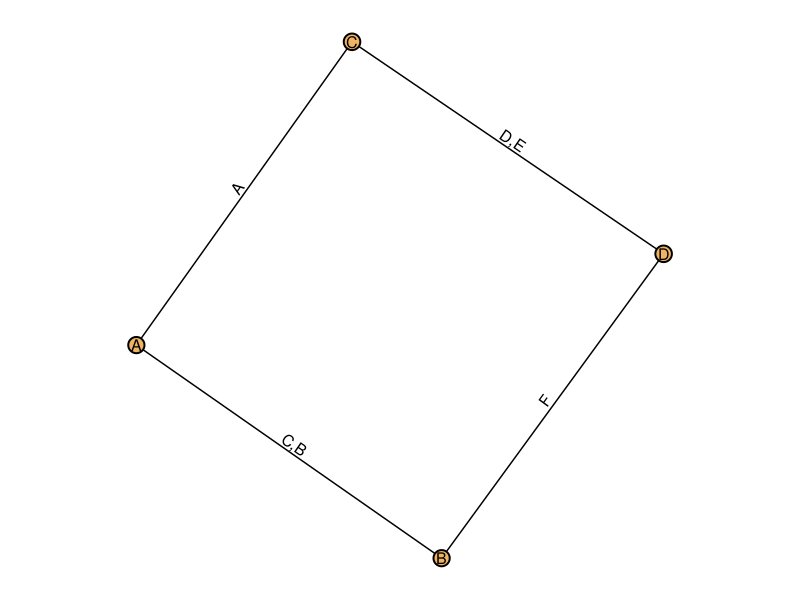

(3, 3, 3)

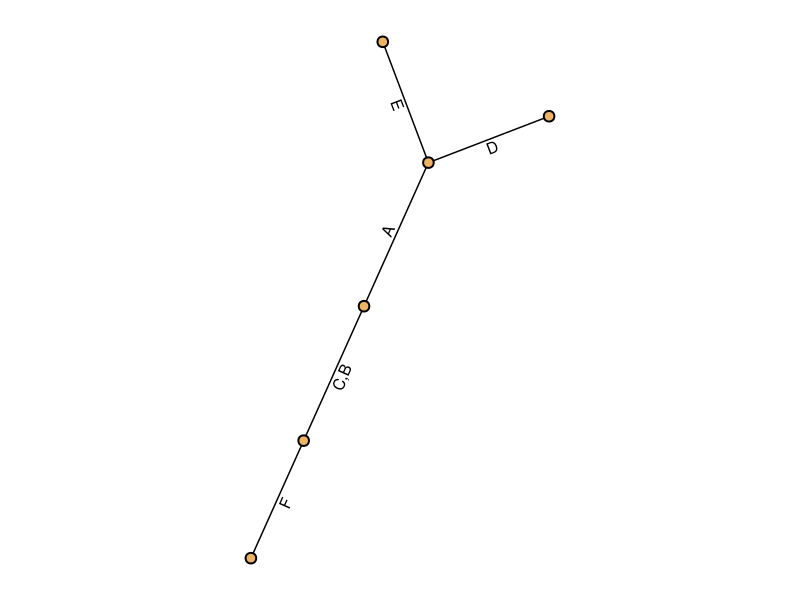

2-element Vector{Any}:
   "full contraction = "
 58.50756722592924

2-element Vector{Any}:
   "Contraction using tree decomposition = "
 19.920905251048783

2-element Vector{Any}:
  "Relative error for approximate contraction = "
 0.6595157482087157

In [31]:
make_plot = true # do you want a visualisation of the TensorNetwork

# Create the tensor network, this will allow me to test my methods
seed1 = 2
TN = rand(Tenet.TensorNetwork, 4::Integer, 3::Integer; out = 0, dim = 3:3, seed = seed1, globalind = false)
println("Tensor network generated=", TN)
initial_contraction = Tenet.contract(TN)[1]



if make_plot == true
    println("Generating plot....")
    # Make a drawing of the tensor network
    # -> Takes a long long time for larger networks...
    drawing = Makie.plot(TN, labels=true, ilabels=["A", "B", "C", "D"], node_size=[1000, 100, 10, 1])
    display(drawing)
end

# select the tensor in the middle (a lot of indices haha)

for tensor in tensors(TN)
    if length(inds(tensor)) == 3
        test = tensor
    end
end
    

display(size(test))





function tensor_rank1approximation(TN, Tensor)
    """
    This function takes in a Tenet.TensorNetwork and a tensor (which is part of this tensor network).
    This Tensor is popped out of the tensor network and gets decomposed into the best Rank-1 Approximation and for each resulting vector a new tensor is added to the network.
    After this modification is done the modified Tenet.TensorNetwork is returned.
    """

    pop!(TN, Tensor)
    indices = inds(Tensor)
    (error, optimized_output_vectors_new, lambda_final) = compute_rank_one_approximation(test, 1e-3, 10000)

    for (k, vector) in enumerate(optimized_output_vectors_new)
        vec_tens = Tenet.Tensor(lambda_final/(length(indices))*vector, (indices[k],))
        push!(TN, vec_tens)
    end
end


tensor_rank1approximation(TN, test)
if make_plot == true
    println("Generating plot....")
    # Make a drawing of the tensor network
    # -> Takes a long long time for larger networks...
    drawing = Makie.plot(TN, labels=true)
    display(drawing)
end

approximated_contraction = Tenet.contract(TN)[1]
relative_error = abs(1-approximated_contraction/initial_contraction)
display(["full contraction = ", initial_contraction])
display(["Contraction using tree decomposition = ", approximated_contraction])
display(["Relative error for approximate contraction = ", relative_error])


